In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,lifelines,rpy2

cs224 
last updated: 2020-03-30 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
lifelines 0.24.2
rpy2 3.2.6


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 41
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

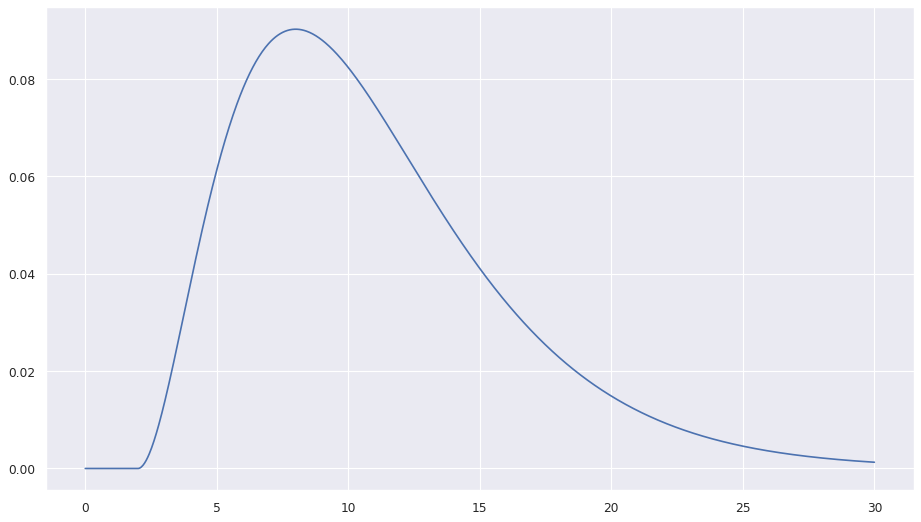

In [5]:
x = np.linspace(0.0,30.0,1000)
gamma_loc   = 2.0
gamma_k     = 3.0
gamme_theta = 3.0
y = stats.gamma(gamma_k, loc=gamma_loc, scale=gamme_theta).pdf(x)
fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(x,y)

In [6]:
china_mortality_analysis = covid19.MortalityAnalysis('China')

In [7]:
china_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,81661,73773,3285,70,493,4
2020-03-26,81782,74181,3291,121,408,6
2020-03-27,81897,74720,3296,115,539,5
2020-03-28,81999,75100,3299,102,380,3
2020-03-29,82122,75582,3304,123,482,5


In [8]:
# china_mortality_analysis.df_lifelines_individual.observed_death.sum()

In [9]:
# china_mortality_analysis.df.head()

In [10]:
# china_mortality_analysis.df.tail()

In [8]:
china_mortality_analysis.fit()

In [12]:
# china_mortality_analysis.wbf.print_summary()

# expected_life_time = china_mortality_analysis.wbf.lambda_ * scipy.special.gamma(1 + 1 / china_mortality_analysis.wbf.rho_)
# expected_life_time/365

In [9]:
china_mortality_analysis.death_rate()

(4.06, 3.93, 4.2)

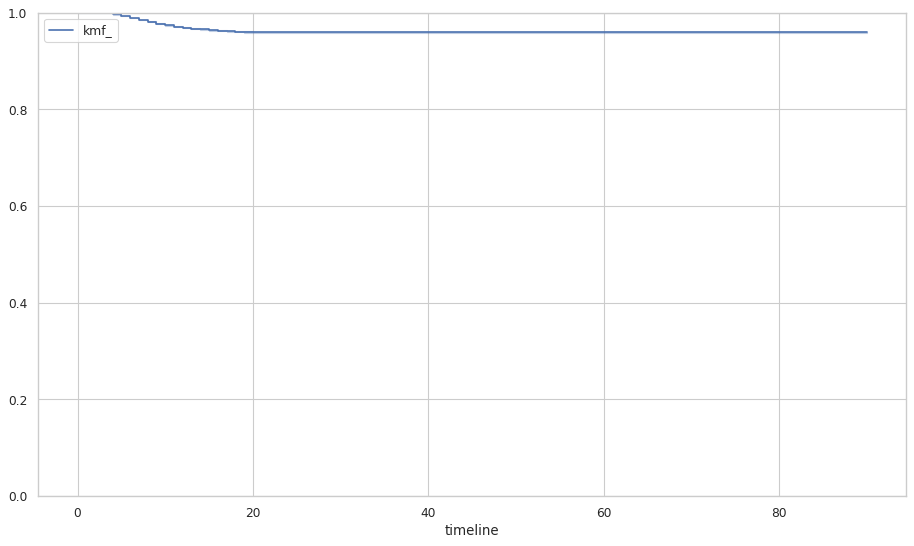

In [10]:
china_mortality_analysis.plot()

(2.26, 2.01, 2.56)


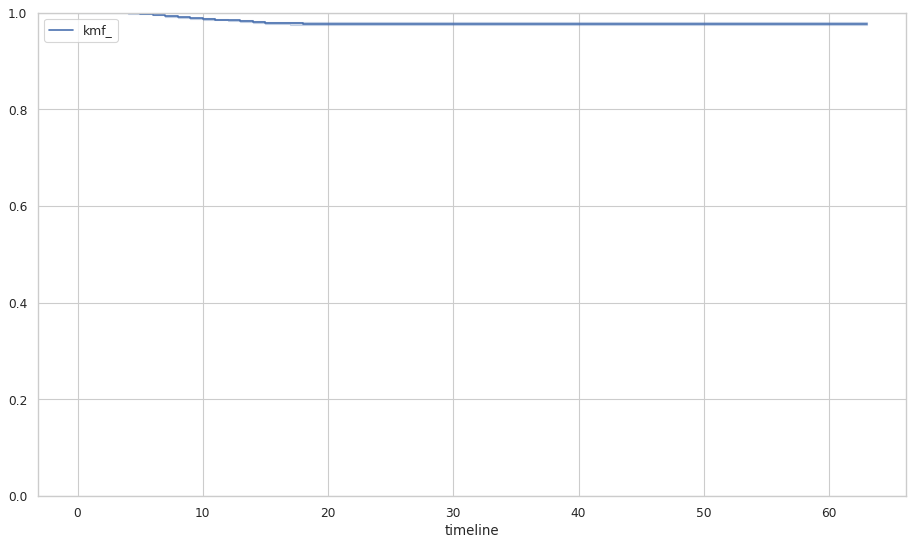

In [11]:
germany_mortality_analysis = covid19.MortalityAnalysis('Germany')
germany_mortality_analysis.fit()
print(germany_mortality_analysis.death_rate())
germany_mortality_analysis.plot()

In [12]:
germany_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,37323,3547,206,4332,257,47
2020-03-26,43211,5678,262,5888,2131,56
2020-03-27,49039,6932,323,5828,1254,61
2020-03-28,54268,8481,398,5229,1549,75
2020-03-29,58655,9291,456,4387,810,58


In [13]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,1326.0,456,870.0,62.0,14,2174.0


In [13]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,1264.0,398,866.0,62.0,14,2166.0


(2.64, 2.05, 3.4)


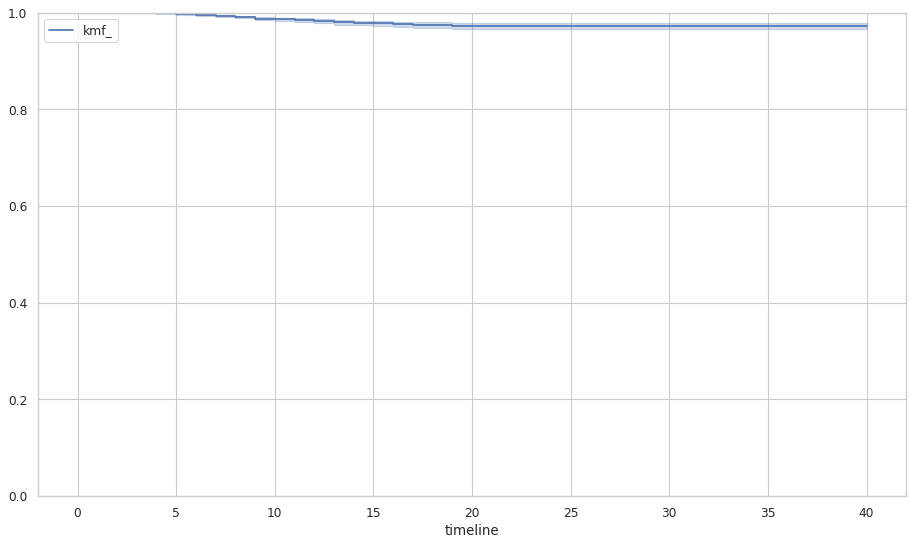

In [14]:
austria_mortality_analysis = covid19.MortalityAnalysis('Austria', first_date=pd.to_datetime('2020-03-12'), init_add=600)
austria_mortality_analysis.fit()
print(austria_mortality_analysis.death_rate())
austria_mortality_analysis.plot()

In [15]:
austria_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,6001,9,42,718,0,14
2020-03-26,6909,112,49,908,103,7
2020-03-27,7657,225,58,748,113,9
2020-03-28,8188,225,68,531,0,10
2020-03-29,8743,479,86,555,254,18


In [16]:
austria_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,247.0,86,161.0,11.0,14,402.0


In [16]:
austria_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,213.0,68,145.0,10.0,14,362.0


(1.76, 1.5, 2.06)
(1.6, 1.36, 1.87)
10483


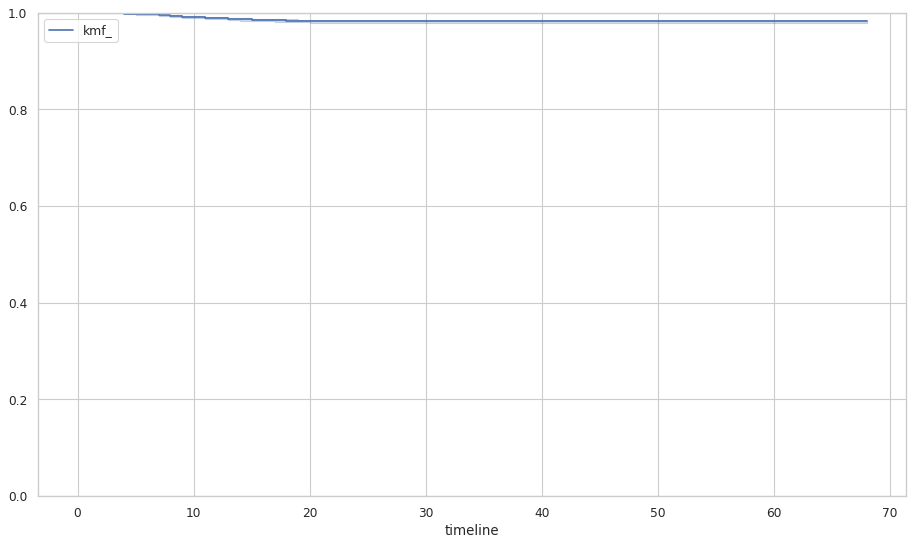

In [17]:
south_korea_name = 'Korea, South'
south_korea_mortality_analysis = covid19.MortalityAnalysis(south_korea_name)
south_korea_mortality_analysis.fit()
south_korea_mortality_analysis2 = covid19.MortalityAnalysis(south_korea_name, first_date=pd.to_datetime('2020-02-20'), init_add=900)
south_korea_mortality_analysis2.fit()
print(south_korea_mortality_analysis.death_rate())
print(south_korea_mortality_analysis2.death_rate())
print(south_korea_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
south_korea_mortality_analysis.plot()

In [18]:
south_korea_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,9241,4144,131,204,637,7
2020-03-26,9241,4144,131,0,0,0
2020-03-27,9332,4528,139,91,384,8
2020-03-28,9478,4811,144,146,283,5
2020-03-29,9583,5033,152,105,222,8


In [20]:
# south_korea_mortality_analysis.prepend_df

(24.17, 22.6, 25.84)
(3.67, 3.43, 3.93)
123480


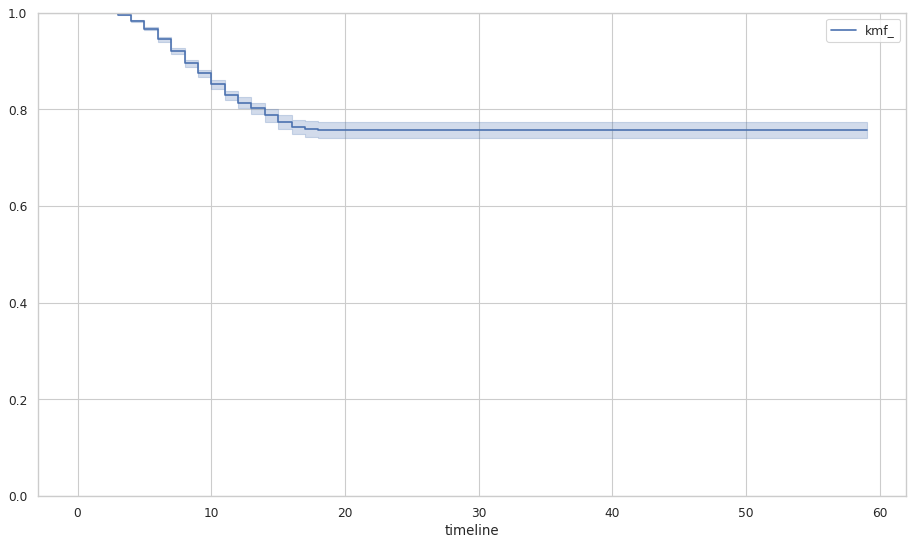

In [19]:
uk_name = 'United Kingdom'
uk_mortality_analysis = covid19.MortalityAnalysis(uk_name)
uk_mortality_analysis.fit()
uk_mortality_analysis2 = covid19.MortalityAnalysis(uk_name, first_date=pd.to_datetime('2020-03-05'), init_add=800, mult=6.0)
uk_mortality_analysis2.fit()
print(uk_mortality_analysis.death_rate())
print(uk_mortality_analysis2.death_rate())
print(uk_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
uk_mortality_analysis.plot()

In [20]:
uk_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,9640,140,467,1476,0,44
2020-03-26,11812,150,580,2172,10,113
2020-03-27,14745,151,761,2933,1,181
2020-03-28,17312,151,1021,2567,0,260
2020-03-29,19780,151,1231,2468,0,210


In [21]:
uk_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,4532.0,1231,3301.0,236.0,14,8252.0


In [21]:
uk_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,3923.0,1021,2902.0,207.0,14,7255.0


In [30]:
# pd.options.mode.chained_assignment = "raise"

(8.15, 7.61, 8.73)
(2.78, 2.59, 2.98)
424008


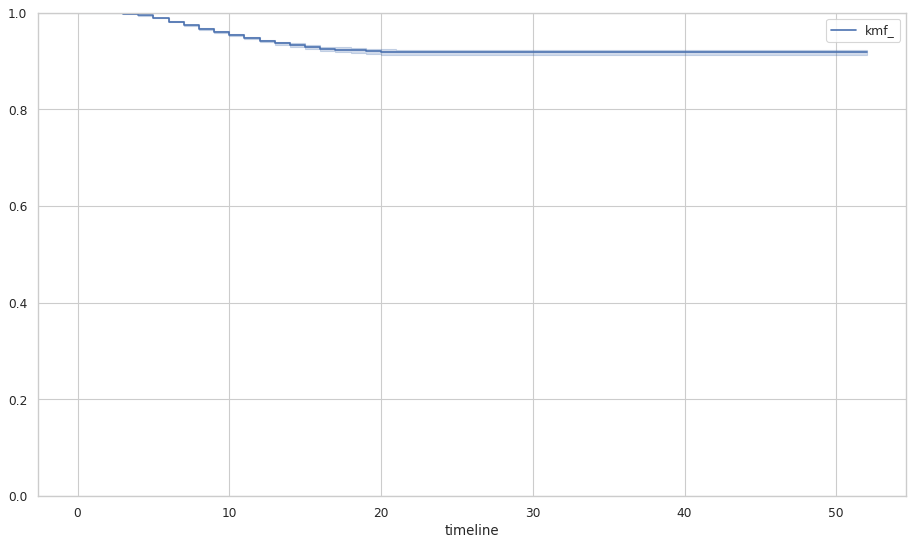

In [22]:
us_mortality_analysis = covid19.MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=950)
us_mortality_analysis.fit()
us_mortality_analysis2 = covid19.MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=450, mult=3.0)
us_mortality_analysis2.fit()
print(us_mortality_analysis.death_rate())
print(us_mortality_analysis2.death_rate())
print(us_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
us_mortality_analysis.plot()

In [23]:
us_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,69197,619,1050,14156,271,260
2020-03-26,85991,753,1296,16794,134,246
2020-03-27,101657,869,1581,15666,116,285
2020-03-28,121478,1072,2026,19821,203,445
2020-03-29,140886,2665,2467,19408,1593,441


In [24]:
us_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,11787.0,2467,9320.0,666.0,14,23301.0


In [24]:
us_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,11010.0,2026,8984.0,642.0,14,22460.0


(21.84, 21.41, 22.29)
(3.05, 2.99, 3.12)
697823


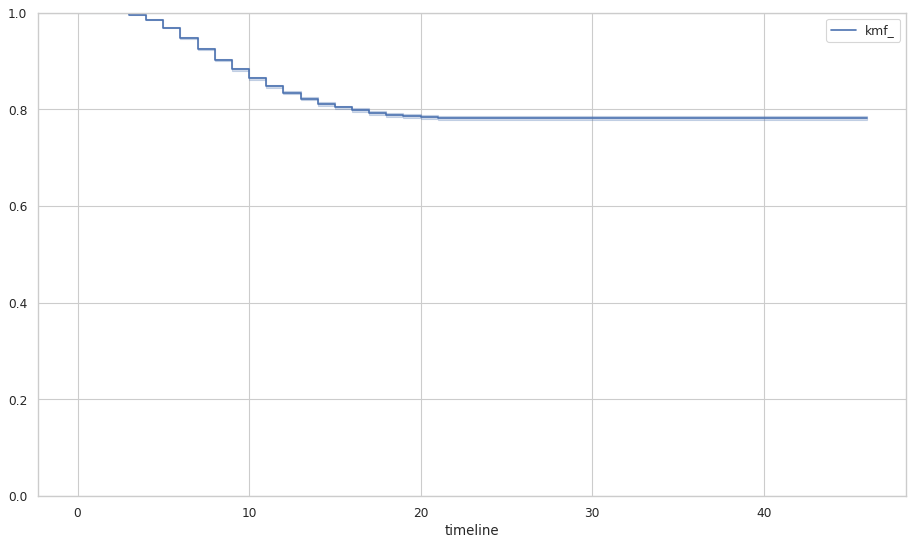

In [25]:
italy_mortality_analysis = covid19.MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'))
italy_mortality_analysis.fit()
print(italy_mortality_analysis.death_rate())
italy_mortality_analysis2 = covid19.MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'), init_add=2000, mult=7.0)
italy_mortality_analysis2.fit()
print(italy_mortality_analysis2.death_rate())
print(italy_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
italy_mortality_analysis.plot()

In [26]:
italy_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,74386,9362,7503,5210,1036,683
2020-03-26,80589,10361,8215,6203,999,712
2020-03-27,86498,10950,9134,5909,589,919
2020-03-28,92472,12384,10023,5974,1434,889
2020-03-29,97689,13030,10779,5217,646,756


In [27]:
italy_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,21284.0,10779,10505.0,750.0,14,26262.0


In [27]:
italy_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,20831.0,10023,10808.0,772.0,14,27020.0


In [37]:
# italy_mortality_analysis2.prepend_df

(25.95, 25.11, 26.81)
(3.49, 3.38, 3.6)
606825


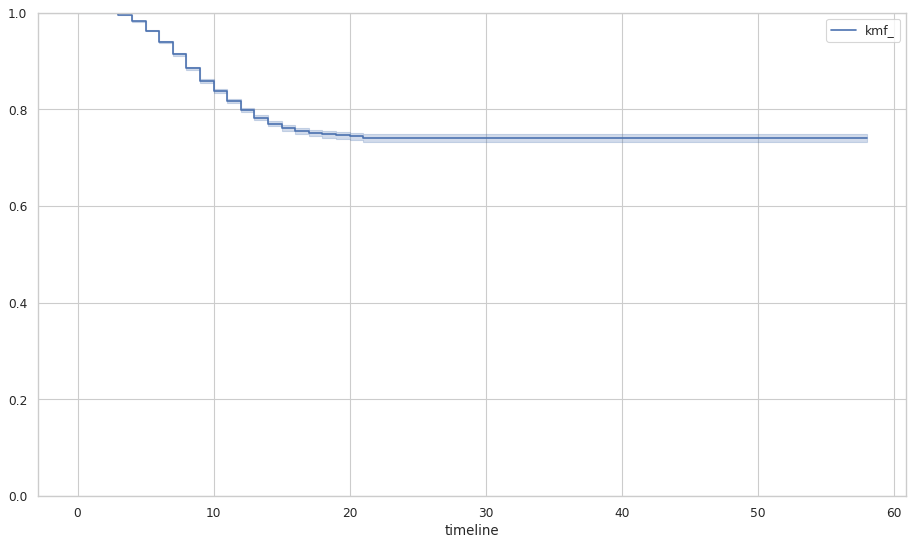

In [28]:
spain_mortality_analysis = covid19.MortalityAnalysis('Spain')
spain_mortality_analysis.fit()
spain_mortality_analysis2 = covid19.MortalityAnalysis('Spain', first_date=pd.to_datetime('2020-03-03'), init_add=800, mult=7.5)
spain_mortality_analysis2.fit()
print(spain_mortality_analysis.death_rate())
print(spain_mortality_analysis2.death_rate())
print(spain_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
spain_mortality_analysis.plot()

In [29]:
spain_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,49515,5367,3647,7457,1573,656
2020-03-26,57786,7015,4365,8271,1648,718
2020-03-27,65719,9357,5138,7933,2342,773
2020-03-28,73235,12285,5982,7516,2928,844
2020-03-29,80110,14709,6803,6875,2424,821


In [30]:
spain_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,21178.0,6803,14375.0,1027.0,14,35938.0


In [30]:
spain_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,20267.0,5982,14285.0,1020.0,14,35713.0


(18.29, 17.48, 19.14)
(3.55, 3.39, 3.72)
206040


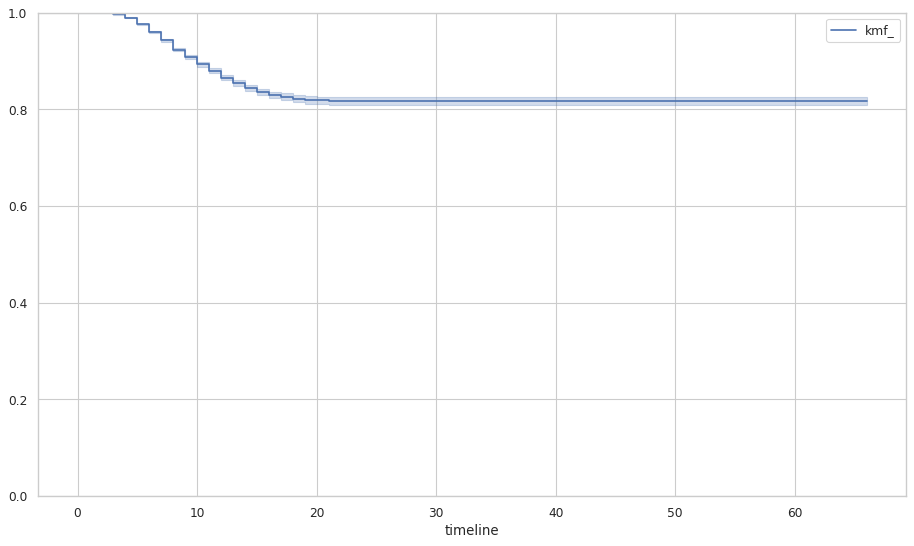

In [31]:
france_mortality_analysis = covid19.MortalityAnalysis('France')
france_mortality_analysis.fit()
france_mortality_analysis2 = covid19.MortalityAnalysis('France', first_date=pd.to_datetime('2020-02-15'), init_add=500, mult=5)
france_mortality_analysis2.fit()
print(france_mortality_analysis.death_rate())
print(france_mortality_analysis2.death_rate())
print(france_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
france_mortality_analysis.plot()

In [32]:
france_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-25,25600,3907,1333,2967,619,231
2020-03-26,29566,4955,1698,3966,1048,365
2020-03-27,33402,5707,1997,3836,752,299
2020-03-28,38105,5724,2317,4703,17,320
2020-03-29,40708,7226,2611,2603,1502,294


In [33]:
france_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,7314.0,2611,4703.0,336.0,14,11759.0


In [33]:
france_mortality_analysis2.project_death_and_hospitalization()

,expected_death,today_death,delta_death,delta_death_across_days,delta_days,required_ventilator_capacity
0,6968.0,2317,4651.0,332.0,14,11628.0


In [34]:
import rpy2
print(rpy2.__version__)

3.2.6


In [35]:
import rpy2.robjects.packages as rpackages
baseR = rpackages.importr('base')
print(baseR.R_Version().rx('version.string'))

$version.string
[1] "R version 3.6.1 (2019-07-05)"




In [36]:
# from rpy2.rinterface import R_VERSION_BUILD
# print(R_VERSION_BUILD)

In [37]:
import IPython.display
import rpy2, rpy2.robjects, rpy2.robjects.pandas2ri, rpy2.rinterface, rpy2.robjects.packages, rpy2.interactive, rpy2.robjects.lib.ggplot2, rpy2.robjects.lib.grdevices
rpy2.robjects.pandas2ri.activate()

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('LexisPlotR',)

# R vector of strings
from rpy2.robjects.vectors import StrVector

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:72: UserWarning: This was designed againt ggplot2 version 3.2.1 but you have 3.3.0
  'have %s' % (TARGET_VERSION, ggplot2.__version__))
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but 

In [38]:
grdevices = rpy2.robjects.packages.importr('grDevices')
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

lexis = importr('LexisPlotR')
lexis

rpy2.robjects.packages.Package as a <module 'LexisPlotR'>

In [39]:
lexis_grid = rpy2.robjects.r['lexis.grid']
lexis_lifeline = rpy2.robjects.r['lexis.lifeline']

In [40]:
def plot_lexis(mortality_analysis_instance):
    mylexis = lexis_grid(year_start = 2020, year_end = 2021, age_start = 0, age_end = 1) #  lwd = 0.1

    alpha = 1.0
    ix_present = ~mortality_analysis_instance.df_lifelines_individual.observed_death
    ix_lost    = mortality_analysis_instance.df_lifelines_individual.observed_death
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_present], exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_present], colour = "orange", alpha = alpha, lwd = 0.4)
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_lost]   , exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_lost]   , colour = "blue"  , alpha = alpha, lwd = 0.4, lineends = True)

    with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=1.5*1024, height=1.5*896, res=90) as img:
        rpy2.robjects.r.print(mylexis)   
    IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

In [41]:
# plot_lexis(italy_mortality_analysis)

In [42]:
# plot_lexis(italy_mortality_analysis2)

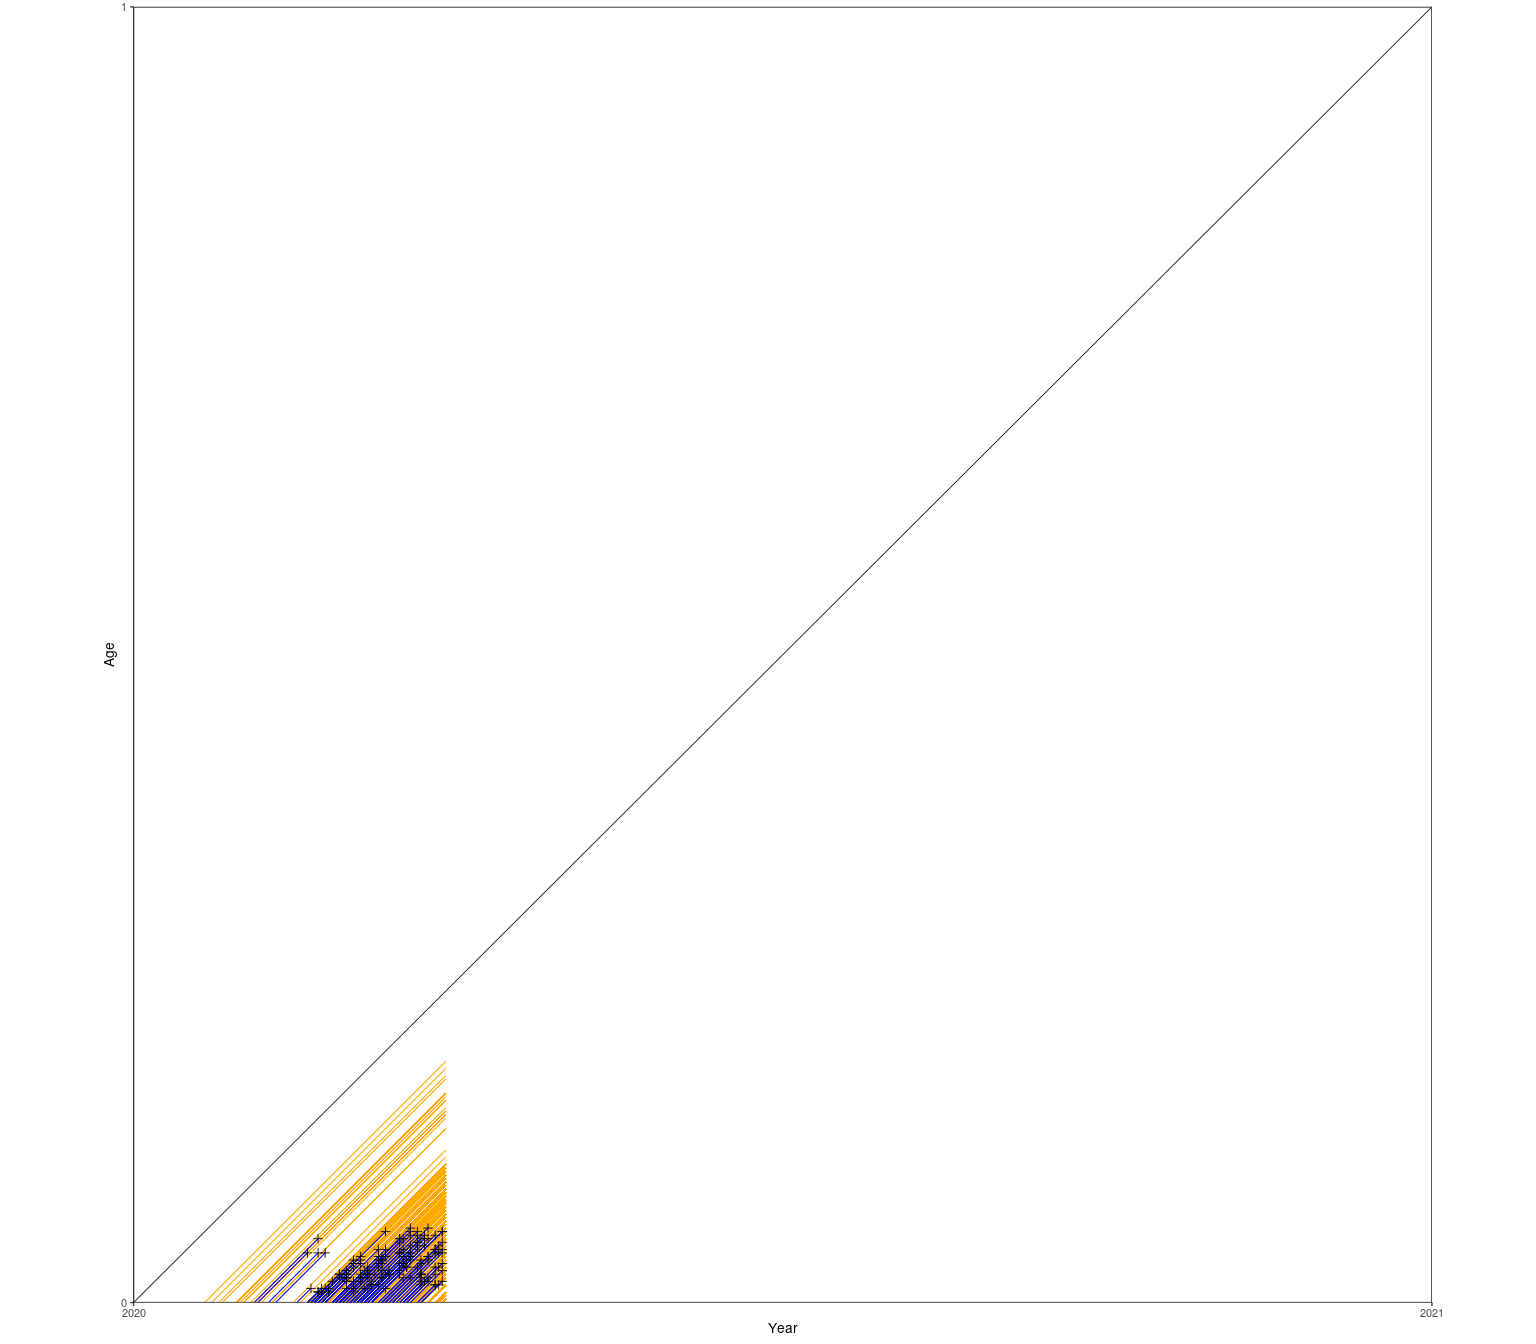

In [43]:
plot_lexis(south_korea_mortality_analysis)